# Description

Input variables:
bank client data:
1. age (numeric)
2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. education (categorical: "unknown","secondary","primary","tertiary")
5. default: has credit in default? (binary: "yes","no")
6. balance: average yearly balance, in euros (numeric) 
7. housing: has housing loan? (binary: "yes","no")
8. loan: has personal loan? (binary: "yes","no") \

related with the last contact of the current campaign:

9. contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. day: last contact day of the month (numeric)
11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. duration: last contact duration, in seconds (numeric) \

other attributes:

13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. previous: number of contacts performed before this campaign and for this client (numeric)
16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):

17. y - has the client subscribed a term deposit? (binary: "yes","no")

# Import Library

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.decomposition import PCA
import matplotlib.ticker as mtick
import matplotlib as mpl
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from imblearn.pipeline import make_pipeline as imbl_pipe
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, TomekLinks
from imblearn.combine import SMOTETomek
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\anaconda3\envs\EnvTensorFlow\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Load Dataset and Quality Checking

In [2]:
df_bank = pd.read_csv("bank-full.csv",sep = ';')

In [3]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [4]:
# check values of columns
df1 = []
for i in df_bank.columns:
    df1.append([i, df_bank[i].isna().sum(), df_bank[i].nunique(), df_bank[i].drop_duplicates().values])

df2 = pd.DataFrame(df1, columns=["column", "null values", "unique number", "values"])
df2

,column,null values,unique number,values
0,age,0,77,"[58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 5..."
1,job,0,12,"[management, technician, entrepreneur, blue-co..."
2,marital,0,3,"[married, single, divorced]"
3,education,0,4,"[tertiary, secondary, unknown, primary]"
4,default,0,2,"[no, yes]"
5,balance,0,7168,"[2143, 29, 2, 1506, 1, 231, 447, 121, 593, 270..."
6,housing,0,2,"[yes, no]"
7,loan,0,2,"[no, yes]"
8,contact,0,3,"[unknown, cellular, telephone]"
9,day,0,31,"[5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21..."


##  Data Numerical

In [5]:
numerical = df_bank.select_dtypes(include = "int64")

In [6]:
df_bank.describe().T

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [7]:
numerical = ["age", "balance", "duration", "campaign", "pdays", "previous"]

In [8]:
df_bank["day"].value_counts()

20    2752
18    2308
21    2026
17    1939
6     1932
5     1910
14    1848
8     1842
28    1830
7     1817
19    1757
29    1745
15    1703
12    1603
13    1585
30    1566
9     1561
11    1479
4     1445
16    1415
2     1293
27    1121
3     1079
26    1035
23     939
22     905
25     840
31     643
10     524
24     447
1      322
Name: day, dtype: int64

## Data Categorical

In [9]:
categorical = df_bank.select_dtypes(include = "object")

In [10]:
df_bank.describe(include="object")

,job,marital,education,default,housing,loan,contact,month,poutcome,y
count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown,no
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959,39922


In [11]:
# Categorical Values
for col in categorical:
    print(f"Value count column {col}:")
    print(df_bank[col].value_counts())
    print()

Value count column job:
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Value count column marital:
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64

Value count column education:
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Value count column default:
no     44396
yes      815
Name: default, dtype: int64

Value count column housing:
yes    25130
no     20081
Name: housing, dtype: int64

Value count column loan:
no     37967
yes     7244
Name: loan, dtype: int64

Value count column contact:
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64

Value count column month:
may    13766
jul     6895
aug     6247
jun     5341
nov 

# Preprocessing

## Change the Data Type

In [12]:
df_bank["day"] = df_bank["day"].astype("object")

## Checking Missing Values

In [13]:
# check missing values
df_bank.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## Checking Outliers

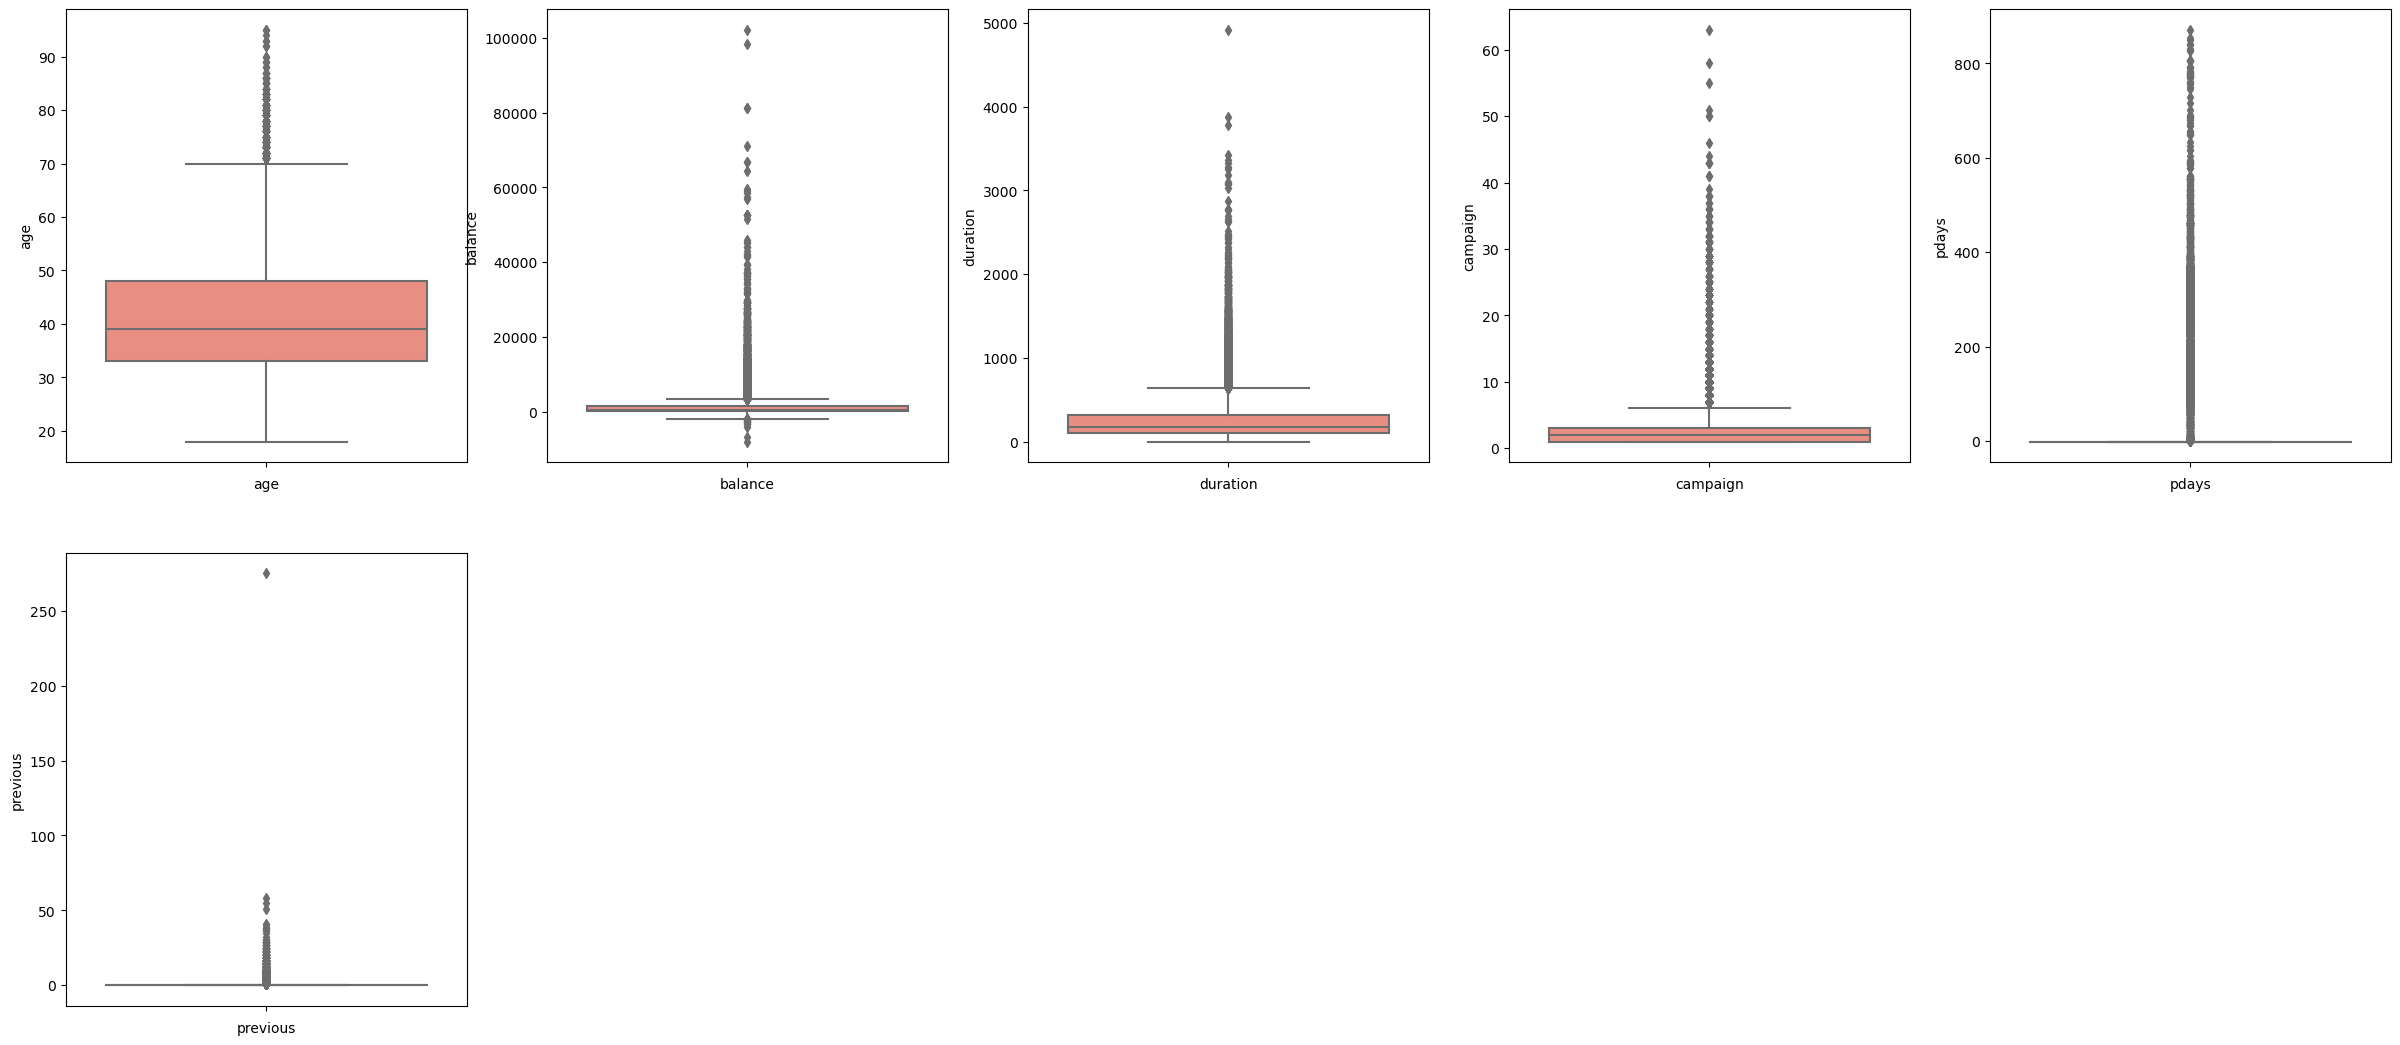

In [14]:
plt.figure(figsize=(30,20))
for i in range(0, len(numerical)):
    plt.subplot(3, 5, i+1)
    sns.boxplot(y=df_bank[numerical[i]], color='salmon', orient='v')
    plt.xlabel(numerical[i]);

Terlihat banyak Outlier pada setiap kolom

## Handling Outliers|

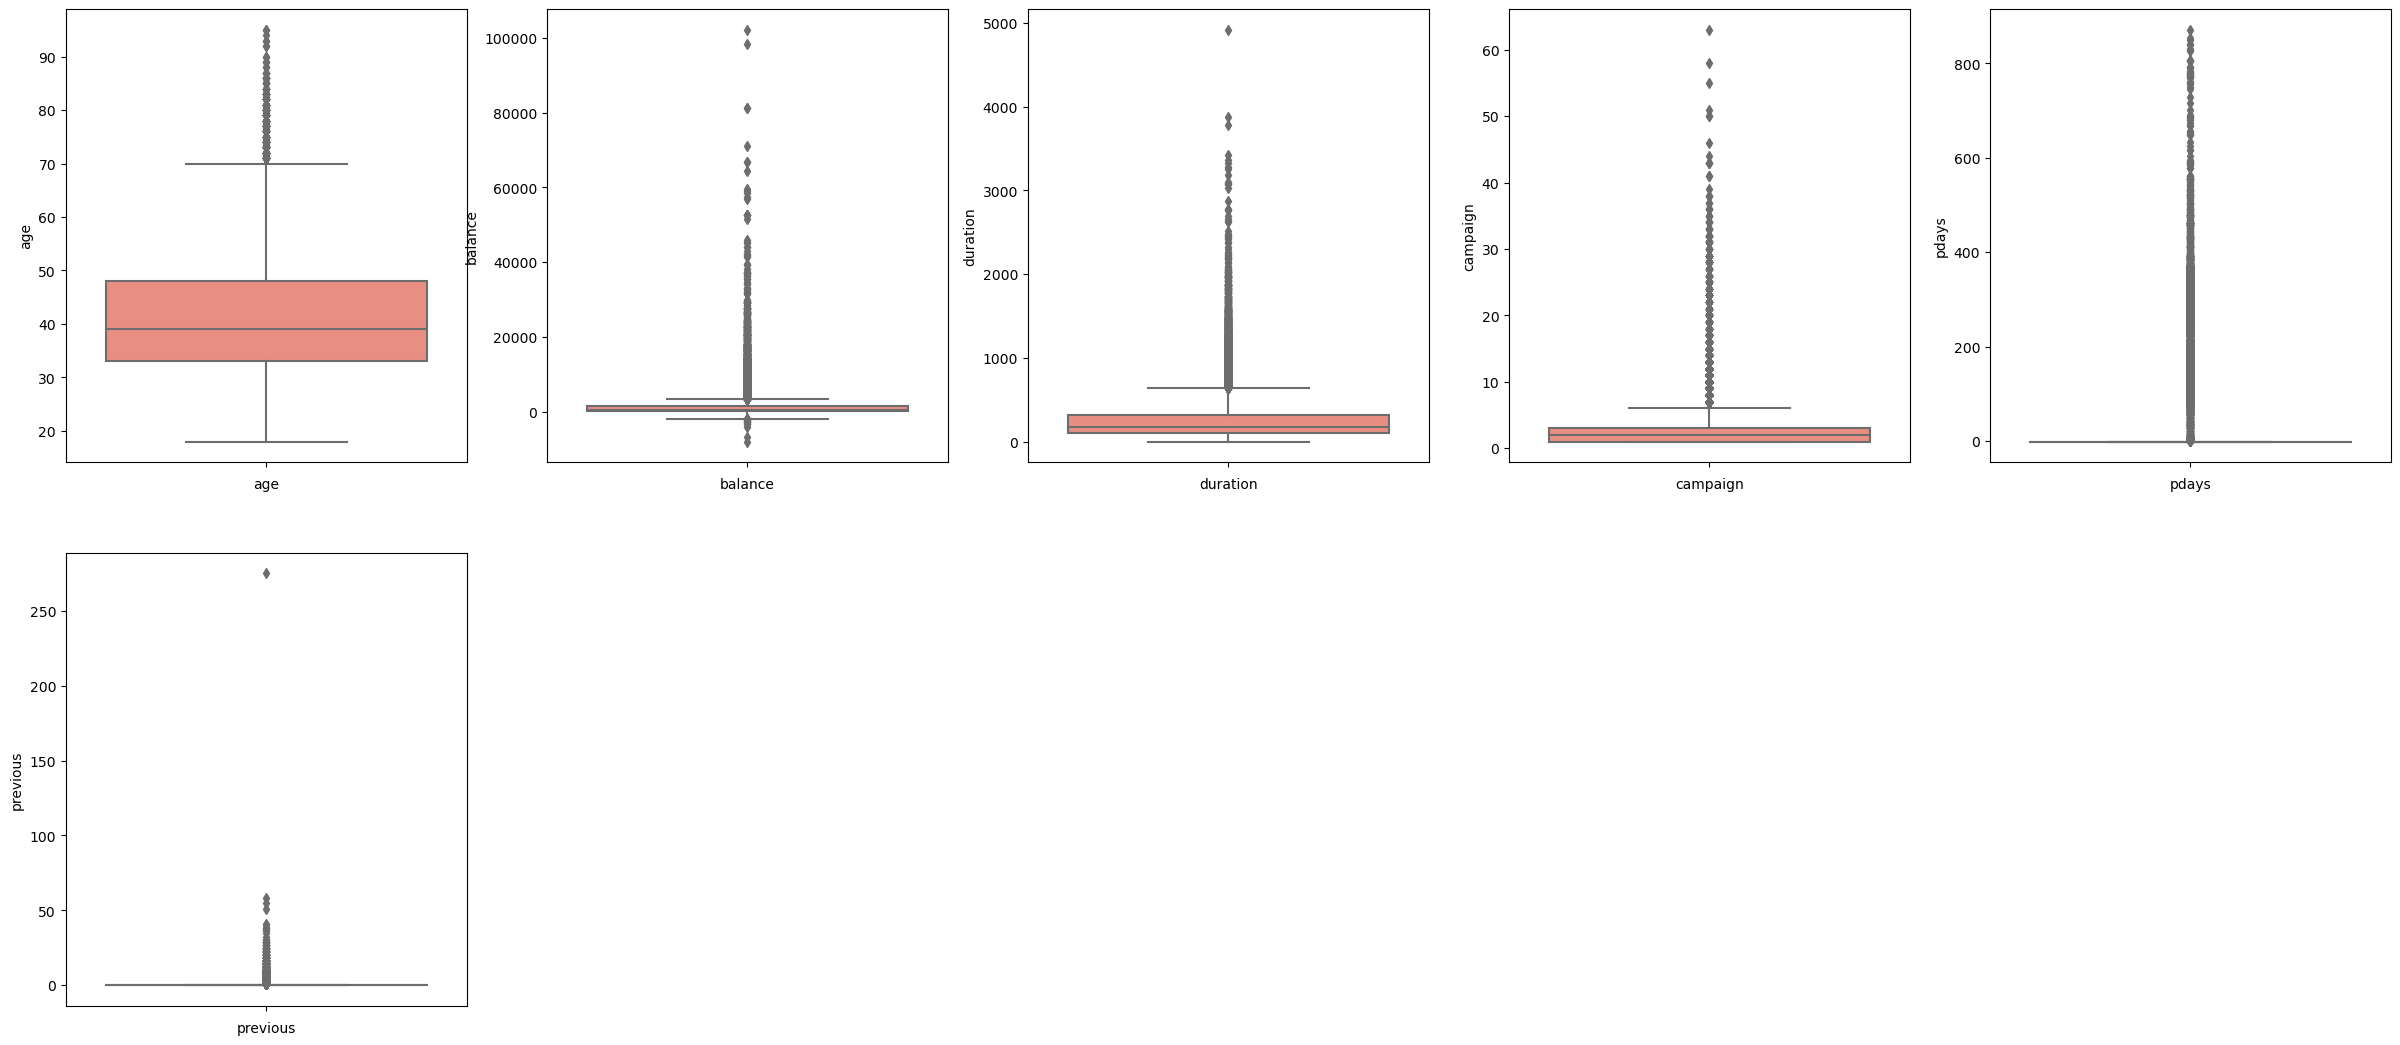

In [15]:
plt.figure(figsize=(30,20))
for i in range(0, len(numerical)):
    plt.subplot(3, 5, i+1)
    sns.boxplot(y=df_bank[numerical[i]], color='salmon', orient='v')
    plt.xlabel(numerical[i]);

In [16]:
def find_outliers(data):
    # tentukan nilai q1 dan q3
    Q1 = np.quantile(data, .25)
    Q3 = np.quantile(data, .75)

    #hitung IQR
    IQR = Q3 - Q1
    min_IQR = Q1 - 1.5 * IQR
    max_IQR = Q3 + 1.5 * IQR

    low_out = []
    upp_out = []

    for i in data:
        if(i < min_IQR):
            low_out.append(i)
        elif(i > max_IQR):
            upp_out.append(i)
    return low_out, upp_out

In [17]:
def count_outliers(segment_by):
    plt.figure(figsize=(7,4))
    sns.boxplot(segment_by)
    plt.show()
    lower_out = find_outliers(segment_by)[0]
    upper_out = find_outliers(segment_by)[1]
    print("Lower Out = ",len(lower_out))
    print("Upper Out = ",len(upper_out))

In [18]:
def pres_outliers (segment_by):
    outliers = find_outliers(segment_by)[0] + find_outliers(segment_by)[1]

    print("Row Data :", len(df_bank))
    print("Outliers :", len(outliers))
    print("Percentage :", round((len(outliers)/len(df_bank))*100,2),"%")

### Age

In [19]:
pres_outliers(df_bank['age'])

Row Data : 45211
Outliers : 487
Percentage : 1.08 %


In [20]:
# hitung nilai IQR dan batas atas
iqr= df_bank['age'].quantile(.75) - df_bank['age'].quantile(.25)
upper_limit = df_bank['age'].quantile(.75) +1.5*iqr

print('Upper Limit :', upper_limit)

Upper Limit : 70.5


In [21]:
# cari batas quantile untuk winsorize
df_bank['age'].quantile(0.98)

63.0

In [22]:
from scipy import stats
df_bank['age'] = stats.mstats.winsorize(df_bank['age'], limits=(0, 0.02))

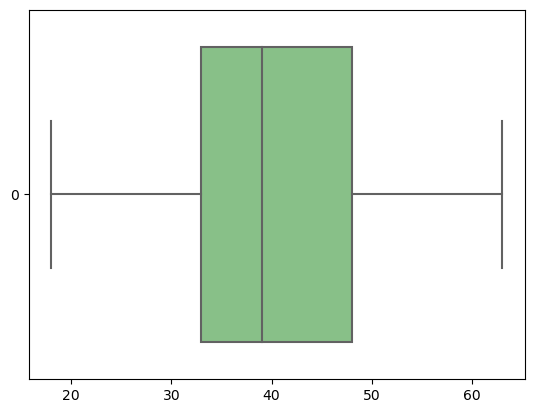

In [23]:
# visualisasi dengan boxplot
sns.boxplot(data=df_bank["age"],palette = 'Accent', orient='h')
plt.show()

### Balance

In [24]:
pres_outliers(df_bank['balance'])

Row Data : 45211
Outliers : 4729
Percentage : 10.46 %


In [25]:
# hitung nilai IQR dan batas atas
iqr= df_bank['balance'].quantile(.75) - df_bank['balance'].quantile(.25)
upper_limit = df_bank['balance'].quantile(.75) +1.5*iqr

print('Upper Limit :', upper_limit)

Upper Limit : 3462.0


In [26]:
# cari batas quantile untuk winsorize
df_bank['balance'].quantile(0.89)

3321.0

In [27]:
from scipy import stats
df_bank['balance'] = stats.mstats.winsorize(df_bank['balance'], limits=(0, 0.11))

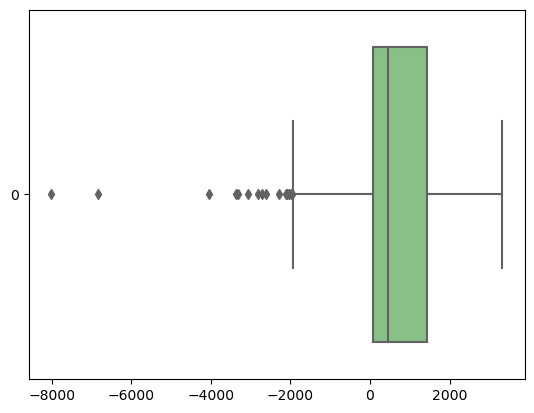

In [28]:
# visualisasi dengan boxplot
sns.boxplot(data=df_bank["balance"],palette = 'Accent', orient='h')
plt.show()

### Duration

In [29]:
pres_outliers(df_bank['duration'])

Row Data : 45211
Outliers : 3235
Percentage : 7.16 %


In [30]:
# hitung nilai IQR dan batas atas
iqr= df_bank['duration'].quantile(.75) - df_bank['duration'].quantile(.25)
upper_limit = df_bank['duration'].quantile(.75) +1.5*iqr

print('Upper Limit :', upper_limit)

Upper Limit : 643.0


In [31]:
# cari batas quantile untuk winsorize
df_bank['duration'].quantile(0.92)

612.0

In [32]:
from scipy import stats
df_bank['duration'] = stats.mstats.winsorize(df_bank['duration'], limits=(0, 0.08))

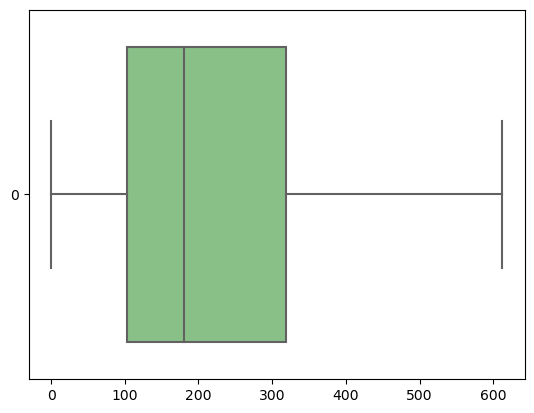

In [33]:
# visualisasi dengan boxplot
sns.boxplot(data=df_bank["duration"],palette = 'Accent', orient='h')
plt.show()

### Campaign

In [34]:
pres_outliers(df_bank['campaign'])

Row Data : 45211
Outliers : 3064
Percentage : 6.78 %


In [35]:
# hitung nilai IQR dan batas atas
iqr= df_bank['campaign'].quantile(.75) - df_bank['campaign'].quantile(.25)
upper_limit = df_bank['campaign'].quantile(.75) +1.5*iqr

print('Upper Limit :', upper_limit)

Upper Limit : 6.0


In [36]:
# cari batas quantile untuk winsorize
df_bank['campaign'].quantile(0.9)

5.0

In [37]:
from scipy import stats
df_bank['campaign'] = stats.mstats.winsorize(df_bank['campaign'], limits=(0, 0.1))

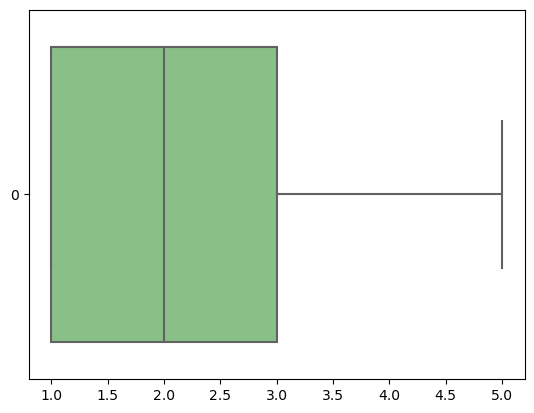

In [38]:
# visualisasi dengan boxplot
sns.boxplot(data=df_bank["campaign"],palette = 'Accent', orient='h')
plt.show()

### Pdays

In [39]:
pres_outliers(df_bank['pdays'])

Row Data : 45211
Outliers : 8257
Percentage : 18.26 %


In [40]:
# hitung nilai IQR dan batas atas
iqr= df_bank['pdays'].quantile(.75) - df_bank['pdays'].quantile(.25)
upper_limit = df_bank['pdays'].quantile(.75) +1.5*iqr

print('Upper Limit :', upper_limit)

Upper Limit : -1.0


In [41]:
# cari batas quantile untuk winsorize
df_bank['pdays'].quantile(0.8)

-1.0

In [42]:
from scipy import stats
df_bank['pdays'] = stats.mstats.winsorize(df_bank['pdays'], limits=(0, 0.02))

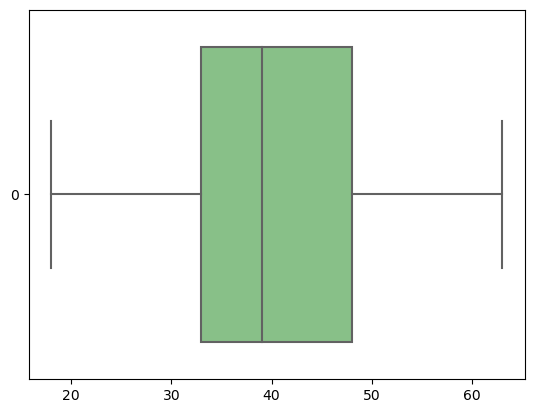

In [43]:
# visualisasi dengan boxplot
sns.boxplot(data=df_bank["age"],palette = 'Accent', orient='h')
plt.show()

### Previous

In [44]:
pres_outliers(df_bank['previous'])

Row Data : 45211
Outliers : 8257
Percentage : 18.26 %


In [45]:
# hitung nilai IQR dan batas atas
iqr= df_bank['previous'].quantile(.75) - df_bank['previous'].quantile(.25)
upper_limit = df_bank['previous'].quantile(.75) +1.5*iqr
print('Upper Limit :', upper_limit)

Upper Limit : 0.0


In [46]:
# cari batas quantile untuk winsorize
df_bank['previous'].quantile(0.95)

3.0

In [47]:
#from scipy import stats
df_bank['previous'] = stats.mstats.winsorize(df_bank['previous'], limits=(0, 0.5))

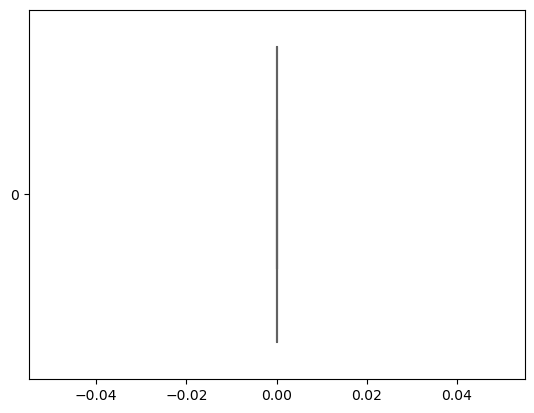

In [48]:
#visualisasi dengan boxplot
sns.boxplot(data=df_bank["previous"],palette = 'Accent', orient='h')
plt.show()

In [49]:
df_bank["previous"]

0        0
1        0
2        0
3        0
4        0
        ..
45206    0
45207    0
45208    0
45209    0
45210    0
Name: previous, Length: 45211, dtype: int64

# Feature Engineering

In [50]:
df_bank

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,612,3,-1,0,unknown,yes
45207,63,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,63,retired,married,secondary,no,3321,no,no,cellular,17,nov,612,5,184,0,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


Melakukan OneHotEncoding pada kolom job, marital, default, housing, loan, contact, month, poutome

Melakukan LabelEncoding pada Y

Melakukan OrdinalEncoding pada Education

## LabelEncoder

In [51]:
# contoh label encoding
labelencoder = LabelEncoder()
print(labelencoder)

LabelEncoder()


In [52]:
# contoh label encoding, gunakan fit_transform untuk encode data
df_bank["y"] = labelencoder.fit_transform(df_bank[["y"]])

In [53]:
df_bank["y"]

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45211, dtype: int32

## One Hot Encoder

In [54]:
# contoh dengan pandas
df_bank = pd.get_dummies(df_bank,prefix='job', columns=['job'])

In [55]:
df_bank

,age,marital,education,default,balance,housing,loan,contact,day,month,...,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown
0,58,married,tertiary,no,2143,yes,no,unknown,5,may,...,0,0,1,0,0,0,0,0,0,0
1,44,single,secondary,no,29,yes,no,unknown,5,may,...,0,0,0,0,0,0,0,1,0,0
2,33,married,secondary,no,2,yes,yes,unknown,5,may,...,1,0,0,0,0,0,0,0,0,0
3,47,married,unknown,no,1506,yes,no,unknown,5,may,...,0,0,0,0,0,0,0,0,0,0
4,33,single,unknown,no,1,no,no,unknown,5,may,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,married,tertiary,no,825,no,no,cellular,17,nov,...,0,0,0,0,0,0,0,1,0,0
45207,63,divorced,primary,no,1729,no,no,cellular,17,nov,...,0,0,0,1,0,0,0,0,0,0
45208,63,married,secondary,no,3321,no,no,cellular,17,nov,...,0,0,0,1,0,0,0,0,0,0
45209,57,married,secondary,no,668,no,no,telephone,17,nov,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df_bank = pd.get_dummies(df_bank,prefix='marital', columns=['marital'])

In [57]:
df_bank = pd.get_dummies(df_bank,prefix='default', columns=['default'], drop_first = True)

In [58]:
df_bank = pd.get_dummies(df_bank,prefix='housing', columns=['housing'], drop_first = True)

In [59]:
df_bank = pd.get_dummies(df_bank,prefix='loan', columns=['loan'], drop_first = True)

In [60]:
df_bank = pd.get_dummies(df_bank,prefix='contact', columns=['contact'])

In [61]:
df_bank = pd.get_dummies(df_bank,prefix='month', columns=['month'])

In [62]:
df_bank = pd.get_dummies(df_bank,prefix='poutcome', columns=['poutcome'])

In [63]:
df_bank

,age,education,balance,day,duration,campaign,pdays,previous,y,job_admin.,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,tertiary,2143,5,261,1,-1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,secondary,29,5,151,1,-1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,secondary,2,5,76,1,-1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,47,unknown,1506,5,92,1,-1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,33,unknown,1,5,198,1,-1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,tertiary,825,17,612,3,-1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
45207,63,primary,1729,17,456,2,-1,0,1,0,...,0,0,0,1,0,0,0,0,0,1
45208,63,secondary,3321,17,612,5,184,0,1,0,...,0,0,0,1,0,0,0,0,1,0
45209,57,secondary,668,17,508,4,-1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## Ordinal Encoder

In [64]:
df_bank["education"].value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

In [65]:
# menentukan urutannya (target guided)
class_order = ["unknown", "primary", "secondary", "tertiary"]

# gunakan estimasi pada fit_transform untuk encode data dengan urutan
df_bank["education"] = OrdinalEncoder(categories=[class_order]).fit_transform(df_bank[["education"]])

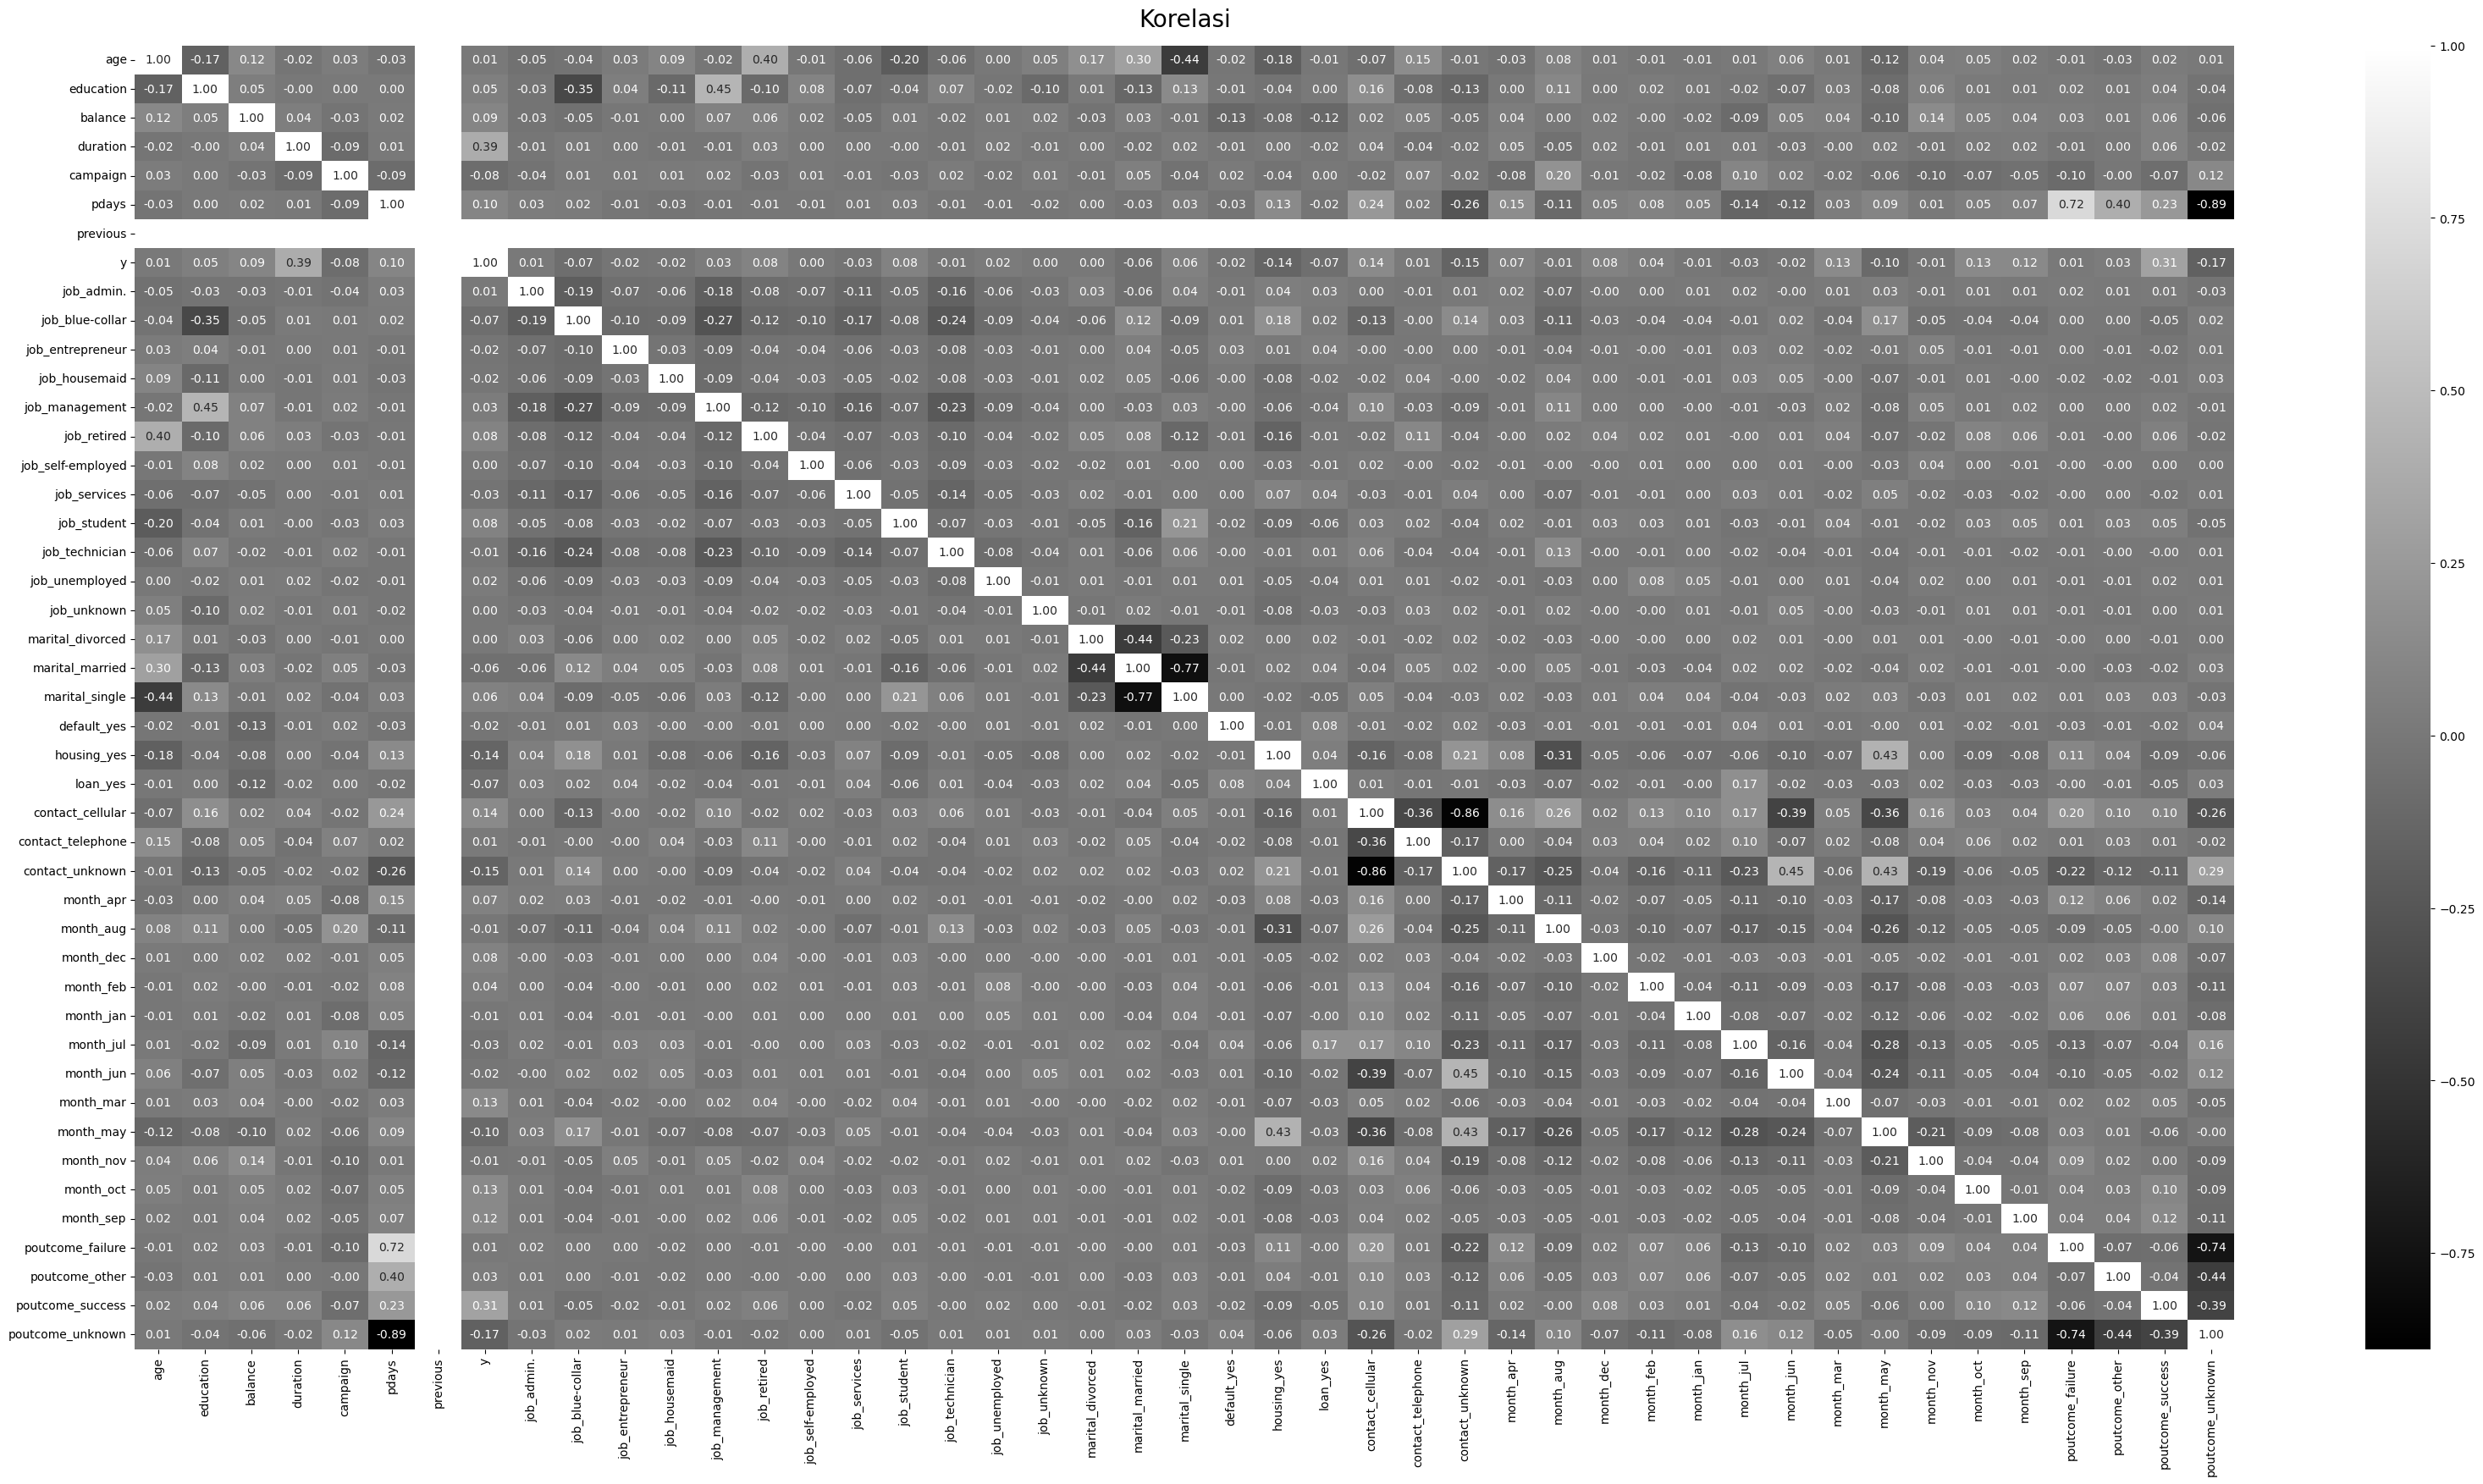

In [66]:
plt.figure(figsize=(40,20))
heatmaps=sns.heatmap(df_bank.corr(),cmap='gray', annot=True, fmt='.2f')
heatmaps.set_title('Korelasi', fontdict={'fontsize':20}, pad=16);

## Scaling Data

In [67]:
df_bank['age'] = MinMaxScaler().fit_transform(df_bank['age'].values.reshape(len(df_bank), 1))
df_bank['duration'] = MinMaxScaler().fit_transform(df_bank['duration'].values.reshape(len(df_bank), 1))
df_bank['balance'] = MinMaxScaler().fit_transform(df_bank['balance'].values.reshape(len(df_bank), 1))
df_bank['campaign'] = MinMaxScaler().fit_transform(df_bank['campaign'].values.reshape(len(df_bank), 1))
df_bank['pdays'] = MinMaxScaler().fit_transform(df_bank['pdays'].values.reshape(len(df_bank), 1))

## Select Feature

In [68]:
X=df_bank.drop(['y'], axis=1)
y=df_bank['y']

In [69]:
anov = SelectKBest(score_func = f_classif)
fit = anov.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

In [70]:
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']

In [71]:
featureScores.nlargest(20, 'Score')

,Specs,Score
4,duration,7933.336383
43,poutcome_success,4697.113837
44,poutcome_unknown,1297.815887
28,contact_unknown,1053.932776
24,housing_yes,892.950576
26,contact_cellular,850.322084
36,month_mar,770.566237
39,month_oct,759.412860
40,month_sep,696.599372
37,month_may,480.019957


In [72]:
# Pemilihan Feature ini bermanfaat untuk menghindari gagalnya memenuhi asumsi multikolinearitas
X_new = X[["duration","poutcome_success","housing_yes","contact_cellular","month_mar","pdays","balance","loan_yes","campaign","job_retired","marital_single"]]

# Model

## Train Test Split

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new,y, test_size=0.2, random_state=42)

In [74]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [75]:
import matplotlib.gridspec as GridSpec
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Logistic Regression

In [76]:
from sklearn.linear_model import LogisticRegression
from yellowbrick.classifier import ROCAUC, ClassificationReport, ClassificationScoreVisualizer
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
model_lr.score(X_test ,y_test)
y_pred=model_lr.predict(X_test)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

0.8941722879575362
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      7952
           1       0.62      0.32      0.42      1091

    accuracy                           0.89      9043
   macro avg       0.77      0.65      0.68      9043
weighted avg       0.88      0.89      0.88      9043



In [77]:
# buat y predict
y_pred = model_lr.predict(X_test)

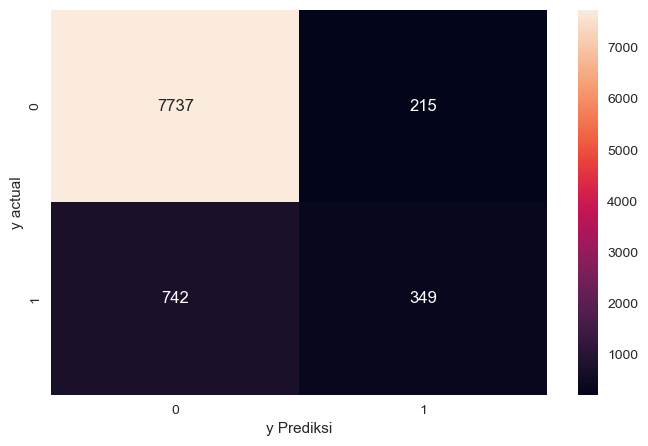

In [78]:
# plot confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y actual')
plt.show()

In [79]:
# cek 1 fold cross val
pd.DataFrame(data = [model_lr.score(X_train, y_train)*100,
                     model_lr.score(X_test, y_test)*100],
             index = ['Model Score in Data Train', 'Model Score in Data Test'],
             columns = ['Score (%)']
            )

,Score (%)
Model Score in Data Train,89.811436
Model Score in Data Test,89.417229


In [80]:
# cek model matrices
pd.DataFrame(data = [accuracy_score(y_test, y_pred)*100, recall_score(y_test, y_pred)*100,
                     precision_score(y_test, y_pred)*100, roc_auc_score(y_test, y_pred)*100,
                     f1_score(y_test, y_pred)*100],
             index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['Score (%)']
            )

,Score (%)
accuracy,89.417229
recall,31.989001
precision,61.879433
roc_auc_score,64.642639
f1_score,42.175227


In [81]:
# fungsi untuk melakukan plot roc auc curve
def plot_roc_curve(true_y, y_prob, labels):
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.6464263929129312



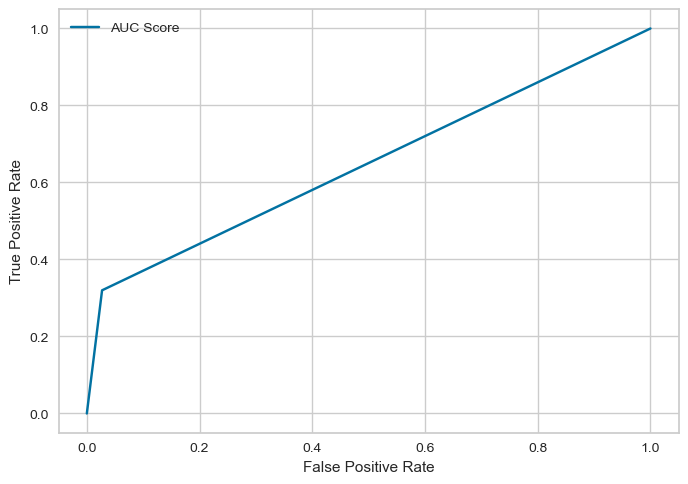

In [82]:
# plot roc auc
plot_roc_curve(y_test, y_pred, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred)}\n")
plt.show()

### Balancing

In [108]:
# gunakan smote untuk oversampling
sm = SMOTE(random_state = 0)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [109]:
# cek sesudah oversampling
print('X_train sesudah oversampling', X_train_sm.shape)
print('y_train sesudah oversampling', y_train_sm.shape, '\n')

print("label '1' sesudah oversampling", sum(y_train_sm == 1))
print("label '0' sesudah oversampling", sum(y_train_sm == 0))

X_train sesudah oversampling (63940, 11)
y_train sesudah oversampling (63940,) 

label '1' sesudah oversampling 31970
label '0' sesudah oversampling 31970


In [110]:
# fitting model dengan data oversampling
model_sm = LogisticRegression()
model_sm.fit(X_train_sm, y_train_sm)

# buat prediksi dengan model oversampling
y_pred_sm = model_sm.predict(X_test)

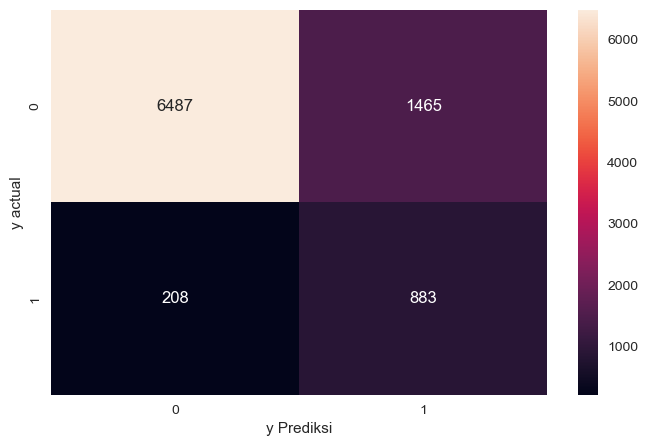

In [111]:
# cek hasil oversampling dengan confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_sm), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y actual')
plt.show()

In [112]:
# cek classification report
print(classification_report(y_test, y_pred_sm))

              precision    recall  f1-score   support

           0       0.97      0.82      0.89      7952
           1       0.38      0.81      0.51      1091

    accuracy                           0.81      9043
   macro avg       0.67      0.81      0.70      9043
weighted avg       0.90      0.81      0.84      9043



In [113]:
# fungsi untuk melakukan plot roc auc curve
def plot_roc_curve(true_y, y_prob, labels):
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.6581631747404685



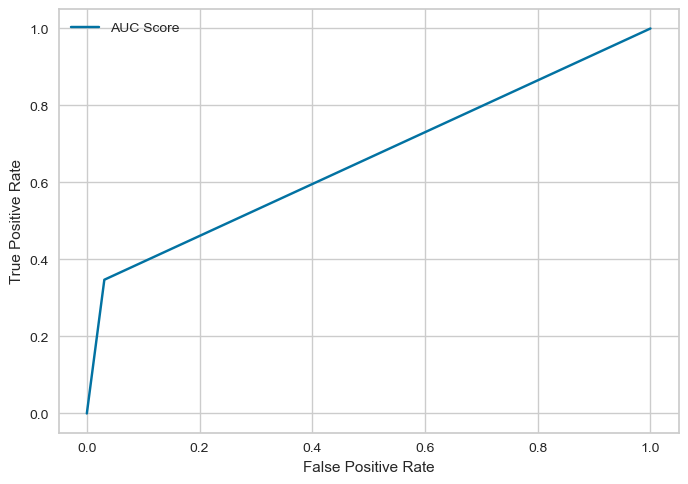

In [114]:
plot_roc_curve(y_test, y_pred, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred)}\n")
plt.show()

In [90]:
from xgboost.sklearn import XGBClassifier
modelXG = XGBClassifier(max_depth=1,
                        learning_rate=0.1, 
                        n_estimators=10, 
                        subsample=0.1, 
                        min_child_weight=1,
                        random_state=10,
                        reg_alpha = 0,
                        reg_lambda = 1)
modelXG.fit(X_train,y_train)

[13:53:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=1, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [91]:
y_pred = modelXG.predict(X_test)

In [92]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      7952
           1       0.85      0.03      0.06      1091

    accuracy                           0.88      9043
   macro avg       0.87      0.52      0.50      9043
weighted avg       0.88      0.88      0.83      9043



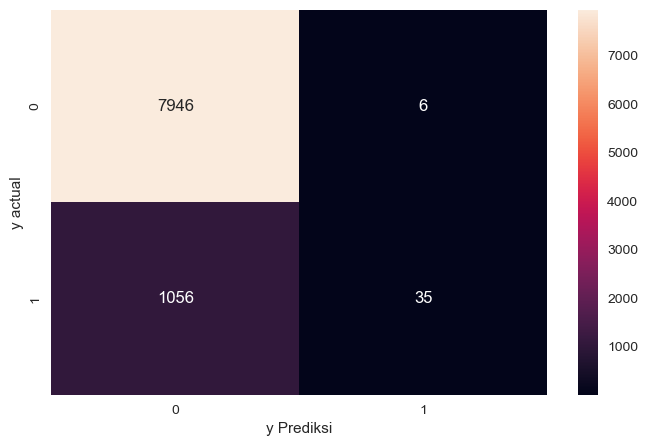

In [93]:
# cek hasil oversampling dengan confusion matrix
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y actual')
plt.show()

In [94]:
def eval_classification(model, pred, xtrain, ytrain, xtest, ytest):
    print("Accuracy (Test Set): %.6f" % accuracy_score(ytest, pred))
    print("Precision (Test Set): %.6f" % precision_score(ytest, pred))
    print("Recall (Test Set): %.6f" % recall_score(ytest, pred))
    print("F1-Score (Test Set): %.6f" % f1_score(ytest, pred))
    
    fpr, tpr, thresholds = roc_curve(ytest, pred, pos_label=1) # pos_label: label yang kita anggap positive
    print("AUC: %.6f" % auc(fpr, tpr))

eval_classification(modelXG, y_pred, X_train, y_train, X_test, y_test)

Accuracy (Test Set): 0.882561
Precision (Test Set): 0.853659
Recall (Test Set): 0.032081
F1-Score (Test Set): 0.061837
AUC: 0.515663


In [95]:
# fungsi untuk melakukan plot roc auc curve
def plot_roc_curve(true_y, y_prob, labels):
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.5156630663910133



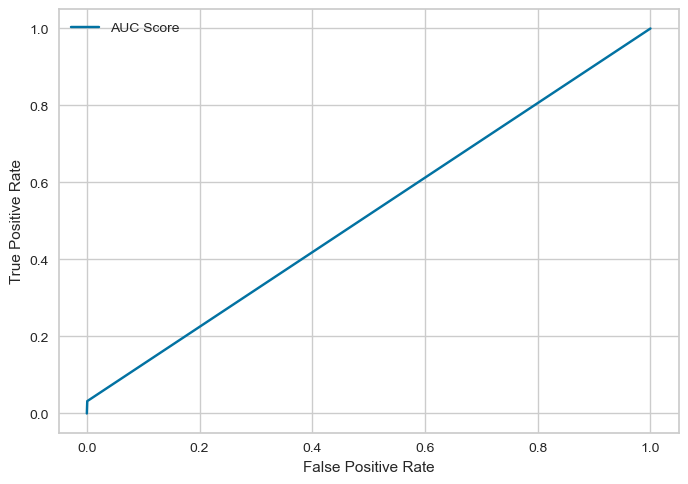

In [96]:
# plot roc auc
plot_roc_curve(y_test, y_pred, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred)}\n")
plt.show()

In [97]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import numpy as np

#Menjadikan ke dalam bentuk dictionary
hyperparameters = {
                    'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
                    'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
                    'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'tree_method' : ['auto', 'exact', 'approx', 'hist'],

                    'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

                    'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
                    'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
                    }

# Init
xg = XGBClassifier(random_state=42)
xg_tuned = RandomizedSearchCV(xg, hyperparameters, cv=5, random_state=42)
xg_tuned.fit(X_train,y_train)

# Predict & Evaluation
y_pred = xg_tuned.predict(X_test)#Check performa dari model
eval_classification(xg_tuned, y_pred, X_train, y_train, X_test, y_test)

[13:53:57] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:59] WARNING:

In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7952
           1       0.61      0.35      0.44      1091

    accuracy                           0.89      9043
   macro avg       0.76      0.66      0.69      9043
weighted avg       0.88      0.89      0.88      9043

